In [138]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

In [ ]:
VALID_IMAGE_EXTENSIONS = ('.png')

class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                valid_image_names = [item for item in image_names if item.lower().endswith(VALID_IMAGE_EXTENSIONS)]
                print(valid_image_names)
                random.shuffle(valid_image_names)
                
                if split == 'train':
                    valid_image_names = valid_image_names[:int(0.6 * len(valid_image_names))]
                elif split == 'val':
                    valid_image_names = valid_image_names[int(0.6 * len(valid_image_names)):int(0.8 * len(valid_image_names))]
                else:  # split == 'test'
                    valid_image_names = valid_image_names[int(0.8 * len(valid_image_names)):]
                
                for image_name in valid_image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
dataset_path = 'images/images'
batch_size = 32
num_epochs = 10
learning_rate = 0.001

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = WasteDataset(dataset_path, split='train', transform=transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [143]:
is_cuda_available = torch.cuda.is_available()
print(f"Is CUDA available? {is_cuda_available}")

if is_cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Is CUDA available? True
Number of GPUs: 1
Using device: cuda:0


In [ ]:
num_classes = len(train_dataset.classes)
model = CNN(num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [145]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

In [146]:
train_accuracy = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)
train_precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
train_recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
train_f1 = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

val_accuracy = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)
val_precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
val_recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(outputs).round()
        train_accuracy.update(preds, labels)
        train_precision.update(preds, labels)
        train_recall.update(preds, labels)
        train_f1.update(preds, labels)
    
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    train_accuracies.append(train_accuracy.compute().item())
    train_precisions.append(train_precision.compute().item())
    train_recalls.append(train_recall.compute().item())
    train_f1s.append(train_f1.compute().item())
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).round()
            val_accuracy.update(preds, labels)
            val_precision.update(preds, labels)
            val_recall.update(preds, labels)
            val_f1.update(preds, labels)
    
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    val_accuracies.append(val_accuracy.compute().item())
    val_precisions.append(val_precision.compute().item())
    val_recalls.append(val_recall.compute().item())
    val_f1s.append(val_f1.compute().item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"  Train Acc: {train_accuracies[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f}")
    print(f"  Train Precision: {train_precisions[-1]:.4f} | Val Precision: {val_precisions[-1]:.4f}")
    print(f"  Train Recall:    {train_recalls[-1]:.4f} | Val Recall:    {val_recalls[-1]:.4f}")
    print(f"  Train F1 Score:  {train_f1s[-1]:.4f} | Val F1 Score:  {val_f1s[-1]:.4f}")
    print("-" * 60)

print("Training completed!")

Epoch [3/10], Train Loss: 0.8405, Val Loss: 1.0471
  Train Loss: 0.8405 | Val Loss: 1.0471
  Train Acc: 0.1790 | Val Acc: 0.2269
  Train Precision: 0.3164 | Val Precision: 0.3550
  Train Recall:    0.1790 | Val Recall:    0.2269
  Train F1 Score:  0.1489 | Val F1 Score:  0.1885
------------------------------------------------------------
Epoch [4/10], Train Loss: 0.2888, Val Loss: 1.0101
  Train Loss: 0.2888 | Val Loss: 1.0101
  Train Acc: 0.2288 | Val Acc: 0.2541
  Train Precision: 0.3893 | Val Precision: 0.3907
  Train Recall:    0.2288 | Val Recall:    0.2541
  Train F1 Score:  0.2035 | Val F1 Score:  0.2218
------------------------------------------------------------
Epoch [5/10], Train Loss: 0.1696, Val Loss: 0.9803
  Train Loss: 0.1696 | Val Loss: 0.9803
  Train Acc: 0.2653 | Val Acc: 0.2790
  Train Precision: 0.4366 | Val Precision: 0.4082
  Train Recall:    0.2653 | Val Recall:    0.2790
  Train F1 Score:  0.2440 | Val F1 Score:  0.2509
-----------------------------------------

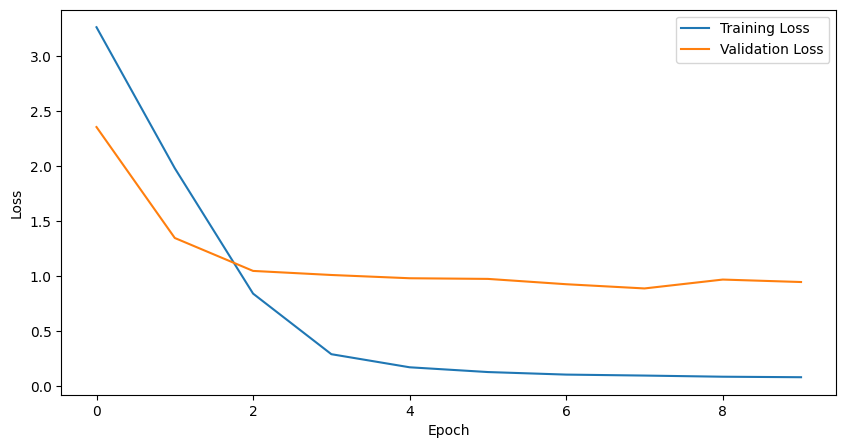

In [147]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to 

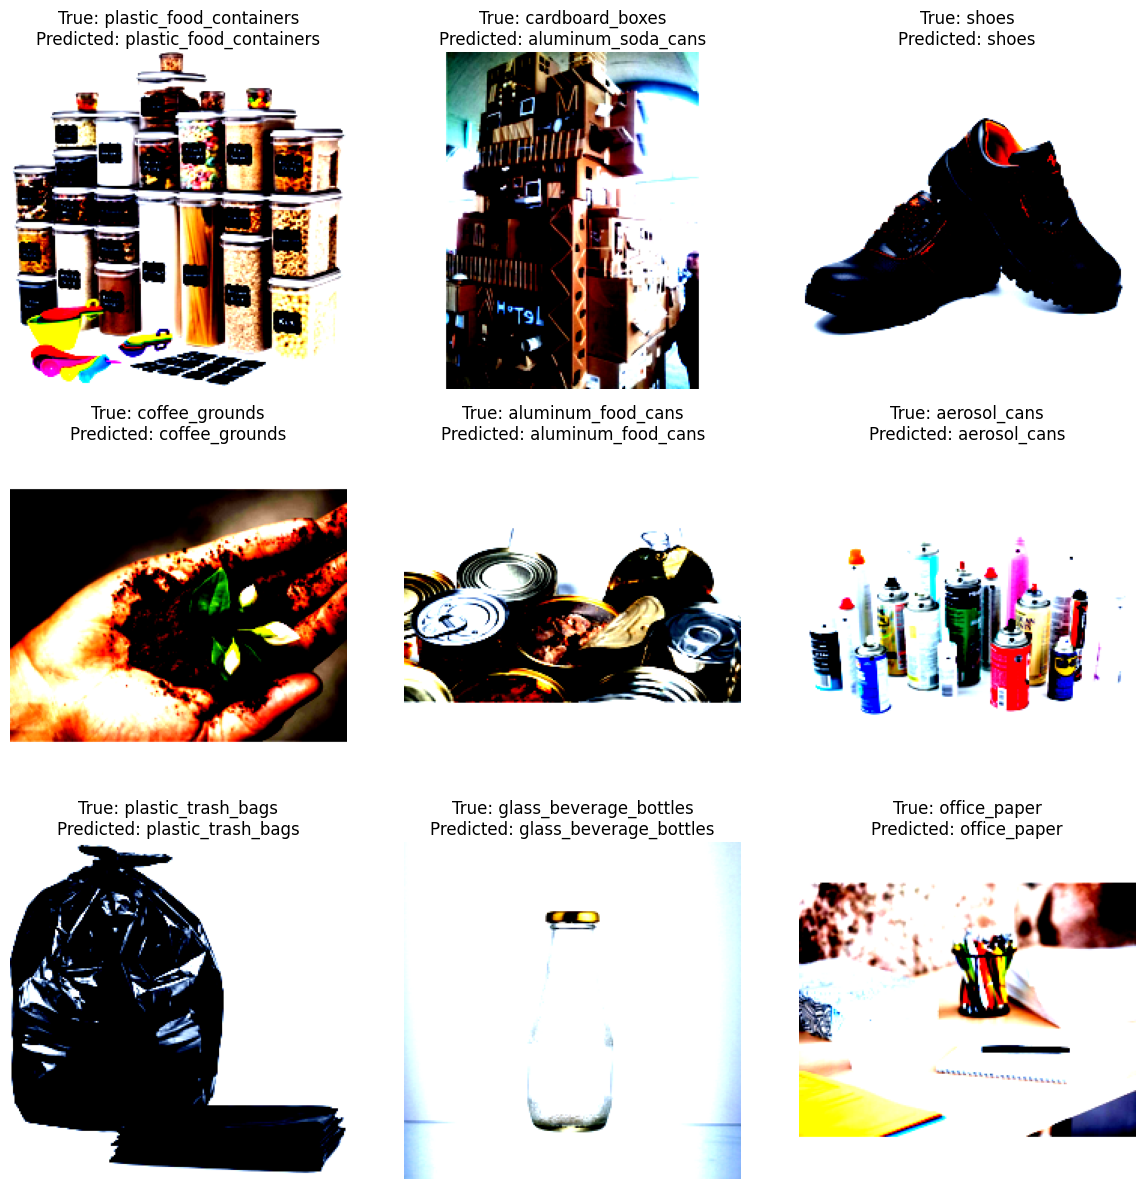

In [148]:
model.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    
    selected_images = []
    selected_labels = []
    selected_predicted = []
    
    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')
        
        output = model(image)
        _, predicted = torch.max(output, 1)
        
        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())
        
        if len(selected_labels) == 9:
            break
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        axes[i].set_title(f"True: {train_dataset.classes[selected_labels[i]]}\nPredicted: {train_dataset.classes[selected_predicted[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [149]:
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "model.pth")
print(f"Saving model to: {model_path}")
torch.save(model.state_dict(), model_path)

Saving model to: models/model.pth


In [ ]:
# loaded_model = CNN(num_classes)
# loaded_model.load_state_dict(torch.load(model_path))

# loaded_model.to(device)
# loaded_model.eval()

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# image_path = "images.jpeg"
# img = Image.open(image_path).convert('RGB')

# input_tensor = transform(img)
# input = input_tensor.unsqueeze(0)
# input = input.to(device)
# output = loaded_model(input)
# _, predicted = torch.max(output, 1)
# print(predicted.item())